# **SIFT (Scale-Invariant Feature Transform) Algorithm Overview**

SIFT is a robust computer vision technique for local feature detection and description.

## Steps:

1. **Scale Space:** Build Gaussian pyramids for different scales.
2. **DoG Pyramid:** Compute Difference of Gaussians for keypoint detection.
3. **Keypoint Detection:** Identify potential keypoints from DoG extrema.
4. **Keypoint Refinement:** Refine keypoints based on stability criteria.
5. **Orientation Assignment:** Assign dominant orientations to keypoints.
6. **Descriptor Generation:** Create local feature descriptors around keypoints.
7. **Matching and Recognition:** Match descriptors for object recognition, image stitching, etc.

SIFT's ability to detect and describe robust local features across scales makes it widely used in various computer vision applications.


### We first include necessary libraries and add a normalization function and a function for visualizing images

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform, util
import skimage.io as io
from skimage.color import rgb2gray
from skimage.filters import sobel_h, sobel_v
from skimage.filters import gaussian
from scipy.ndimage import maximum_filter, minimum_filter
from scipy.signal import convolve
from skimage.transform import rotate
import pandas as pd
import cv2
import time
%matplotlib inline

In [7]:
def normalize_img(img):
    """
    Normalize pixel values of an image to the range [0, 1].

    Parameters:
    - img (numpy.ndarray): Input image as a NumPy array.

    Returns:
    - numpy.ndarray: Normalized image with pixel values in the range [0, 1].

    Example:
    >>> img = np.array([[10, 20, 30], [40, 50, 60]])
    >>> normalize_img(img)
    array([[0. , 0.2, 0.4],
           [0.6, 0.8, 1. ]])
    """
    img_min = np.min(img)
    img_max = np.max(img)
    normalized_img = (img - img_min) / (img_max - img_min)
    return normalized_img


In [8]:
def show_images(imgs, imgs_labels=None, figsize=(20, 10)):
    """
    Display images horizontally using Matplotlib subplots.

    Parameters:
    - imgs: List of images (NumPy arrays) to display.
    - imgs_labels: (Optional) List of labels corresponding to the images.

    Example Usage:
    show_images([image1, image2], ['Label 1', 'Label 2'])
    """
    # Create a figure with subplots based on the number of images
    fig, axes = plt.subplots(1, len(imgs), figsize=figsize)

    # Plot each image on its respective subplot
    for i in range(len(imgs)):
        axes[i].imshow(imgs[i], cmap="gray")  # Display image in grayscale
        if imgs_labels:
            axes[i].set_title(imgs_labels[i])  # Set title if labels provided

    # Show the plot
    plt.tight_layout()
    plt.show()


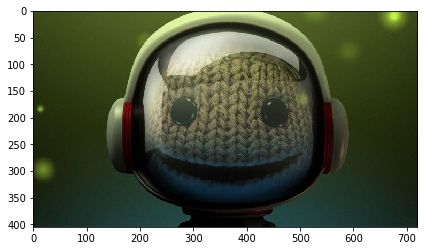

In [101]:
img = io.imread("img3.jpg")
io.imshow(img)
plt.show()

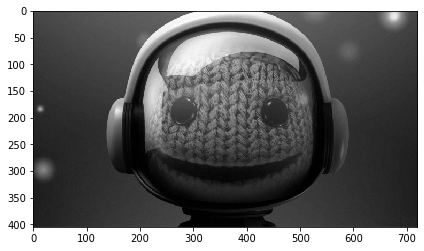

In [102]:
# convert to grayscale and normalize
img = normalize_img(rgb2gray(img))
# img = transform.rotate(img, 5)
io.imshow(img, cmap='gray')
plt.show()

**Before starting, some terminologies must be clear**

Scale: Refers to the level or degree of Gaussian blurring applied to an image. It determines the amount of detail present in different versions of the same image.

Octave: Represents a series of images derived from the original image by applying Gaussian blurring and subsampling. Each octave contains images of different sizes (downsampled versions) but maintaining the same content at different scales.

Scale space: It encompasses the collection of octaves, each containing a series of images at varying scales (achieved by applying Gaussian blurring and downsampling). The scale space is essentially the entire set of images generated through different octaves and their respective scales.

## Step1: Build Gaussian pyramids for different scales.


In [103]:
def generate_octave(img, lvls):
    """
    Generates a list of images by rescaling the input image at different levels.

    Parameters:
    - img: Input image (NumPy array).
    - lvls: List of scaling levels.

    Returns:
    - generated_imgs: List of images rescaled at different levels.
    """
    generated_imgs = [cv2.resize(img, (0, 0), fx=1.0/lvl, fy=1.0/lvl) for lvl in lvls]
    return generated_imgs


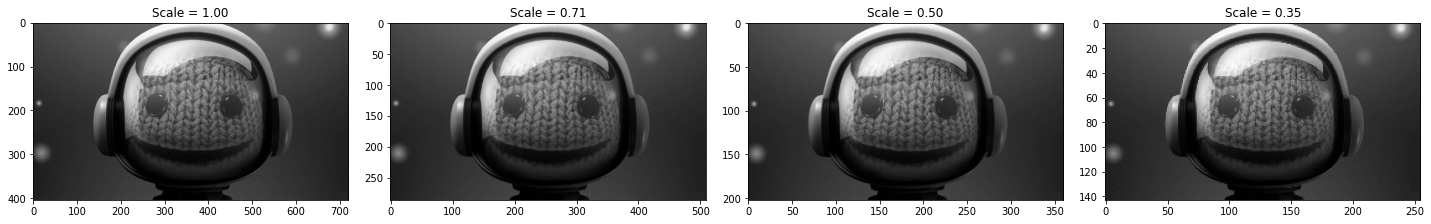

In [104]:
octave_lvls = [1.0]  # Starting scale factor, e.g., 1.0
num_octave_levels = 4

for i in range(num_octave_levels - 1):
    octave_lvls.append(np.sqrt(2) * octave_lvls[-1])

DoG_list = generate_octave(img, octave_lvls)
show_images(DoG_list, [f"Scale = {1/i:.2f}" for i in octave_lvls])

In [105]:
def generate_different_scales(img, sigmas):
    """
    Generates a list of images by applying Gaussian blur to the input image at different sigma values.

    Parameters:
    - img: Input image (NumPy array).
    - sigmas: List of sigma values for Gaussian blurring.

    Returns:
    - generated_imgs: List of images blurred at different sigma values.
    """
    blurred_images = [cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma) for sigma in sigmas]
    return blurred_images


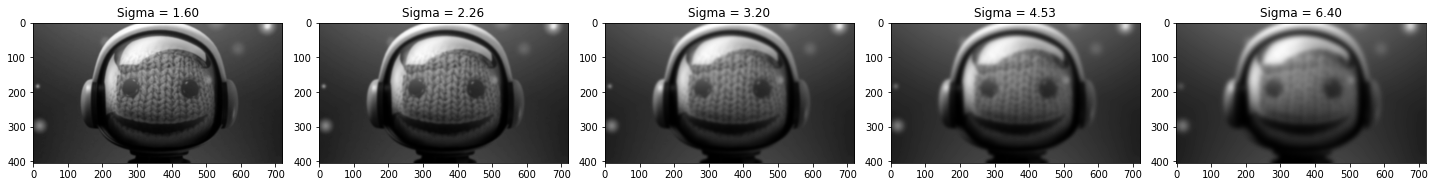

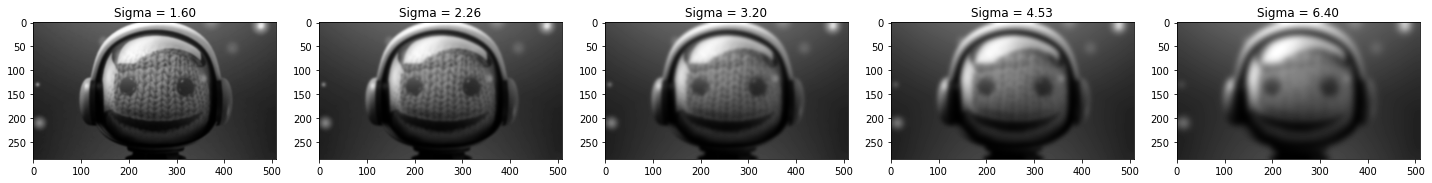

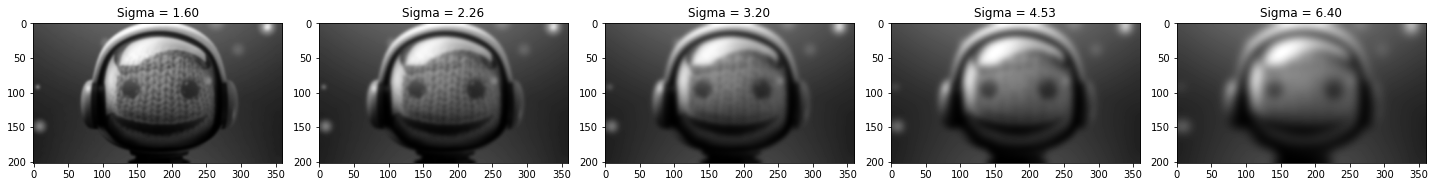

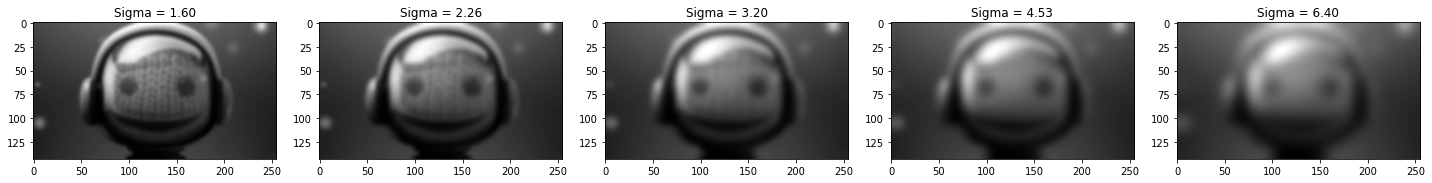

In [106]:
scale_space = []
sigma = 1.6
k = np.sqrt(2)

sigmas = [sigma, k * sigma, k**2 * sigma, k**3 * sigma, k**4 * sigma]
for i in range(len(DoG_list)):
    blurred_imgs = generate_different_scales(DoG_list[i], sigmas)
    show_images(blurred_imgs, [f"Sigma = {i:.2f}" for i in sigmas])
    scale_space.append(blurred_imgs)

## Step2: Compute Difference of Gaussians for keypoint detection.

In [107]:
def DoG(imgs_list):
    """
    Computes the Difference of Gaussians (DoG) for a list of images.

    Parameters:
    - imgs_list: List of images.

    Returns:
    - DoG_list: List of images representing the differences between consecutive scales.
    """
    DoG_list = [imgs_list[i] - imgs_list[i - 1] for i in range(1, len(imgs_list))]
    return DoG_list

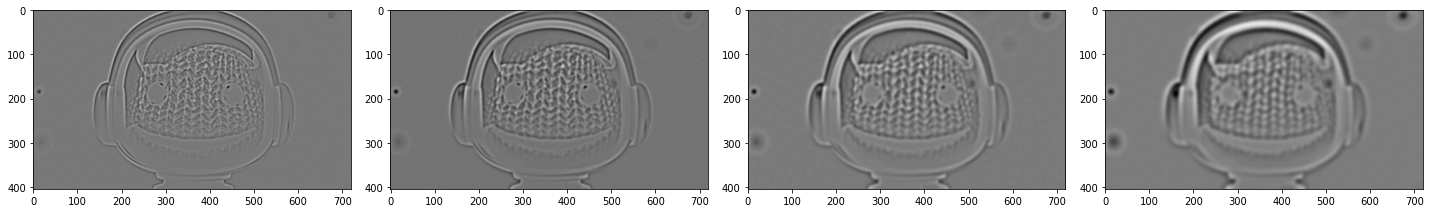

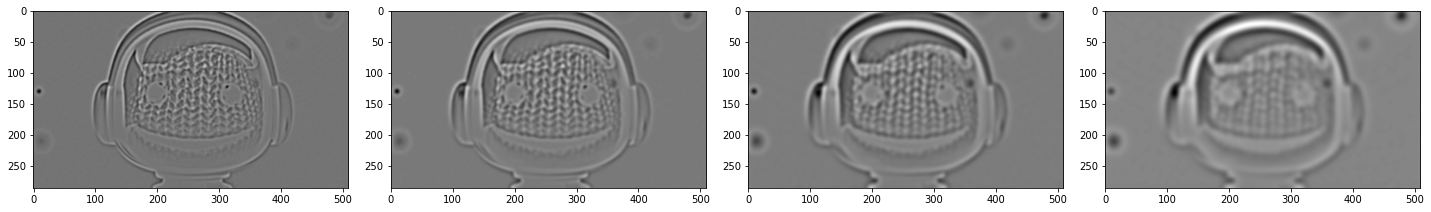

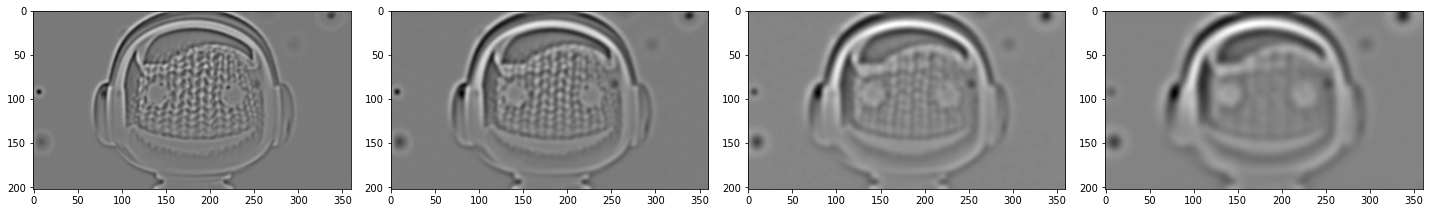

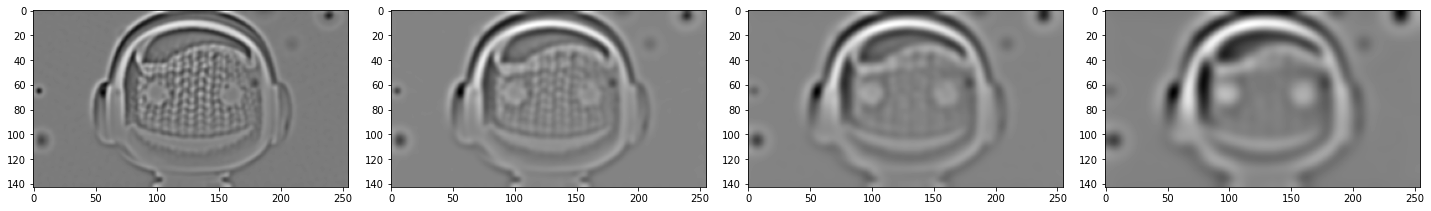

In [108]:
DoG_space = []
for imgs_list in scale_space:
    DoG_list = DoG(imgs_list)
    DoG_space.append(DoG_list)
    show_images(DoG_list)

## Step3: Keypoint Detection
Identify potential keypoints from DoG extrema.

A keypoint in an image is a corner point, and in order to determine whether a point is a corner point or not, we use something called *Harris corner detector*

The Harris corner detector is an algorithm used in computer vision to identify corners or interest points in an image. It's not specifically an edge detector but is often used alongside edge detection methods for feature extraction.

#### Functionality

The Harris corner detection algorithm operates by:

1. **Image Gradients:**
   - Calculating gradients in the image to find changes in intensity in both x and y directions.

2. **Structure Tensor Calculation:**
   - Computing the structure tensor for each pixel, involving the products of gradients.

3. **Sum of Squares of Gradients:**
   - Calculating the sum of squares of gradients using the structure tensor elements.

4. **Corner Response Function:**
   - The cornerstone of the Harris corner detection algorithm is the corner response function.
   - It evaluates the local change in intensity for small displacements in different directions around a pixel.
   - The function assesses the significance of intensity changes when the image is shifted.
   - Mathematically, the corner response function is defined as:
     ```
     R = det(M) - k * trace(M)^2
     ```
     - Where:
       - `det(M)` is the determinant of the structure tensor `M`.
       - `trace(M)` is the trace of the structure tensor `M`.
       - `k` is an empirically determined constant (typically 0.04 to 0.06).
   - Higher values of `R` indicate a stronger response and a higher likelihood of the pixel being part of a corner or an interest point.

5. **Thresholding or Non-Maximum Suppression:**
   - Applying a threshold or non-maximum suppression to the computed corner response values to identify potential corners or interest points.


In [109]:
from numba import jit
@jit(nopython=True)
def get_keypoints(DoG_list, thresh=0.03):  # check that image values are between 0 and 1
    """
    Detects potential keypoints in Difference of Gaussian (DoG) images.

    Args:
    - DoG_list (list of arrays): A list containing Difference of Gaussian images.
    - thresh (float): Threshold value for identifying potential keypoints (default: 0.55).

    Returns:
    - total_keypoints (list of lists of tuples): A list containing coordinates of identified keypoints for each DoG image.

    Notes:
    - The function iterates through the DoG images in 'DoG_list' and identifies potential keypoints.
    - 'thresh' determines the sensitivity of keypoint detection.
    - Output 'total_keypoints' contains lists of keypoints corresponding to each DoG image.
    """
    candidate_keypoints = []
    H, W = DoG_list[0].shape
    
    for i in range(1, len(DoG_list)-1):  # i is the scale (blur lvl)
        full_tensor = np.empty((3,) + DoG_list[0].shape)  # Create an empty array to hold stacked data
        full_tensor[0] = DoG_list[i-1]
        full_tensor[1] = DoG_list[i]
        full_tensor[2] = DoG_list[i+1]
        for y in range(1, H-1):
            for x in range(1, W-1):
                if(DoG_list[i][y, x] > thresh or DoG_list[i][y, x] < -thresh):
                    tensor = full_tensor[:, y-1:y+2, x-1:x+2]
                    if(DoG_list[i][y, x] == np.max(tensor) or DoG_list[i][y, x] == np.min(tensor)):
                        candidate_keypoints.append([x, y, i])
    
    return candidate_keypoints

In [110]:
%time keypoints = get_keypoints(np.array(DoG_space[0]))  # numba is faster if the input is a np array

Wall time: 942 ms


In [111]:
# Combine prev function and the following function in one function

## Step4: Keypoint Refinement
Refine keypoints based on stability criteria.

In [112]:
def filter_keypoints(keypoints, DoG_list, r=10):
    """
    Refines detected keypoints by filtering based on the Hessian matrix.

    Args:
    - keypoints (list of tuples): Coordinates of keypoints [(x1, y1), (x2, y2), ...].
    - img (numpy array): The image array where keypoints are detected.
    - r (int): Parameter used for Hessian matrix filtering (default: 6).

    Returns:
    - filtered_keypoints (list of tuples): Refined keypoints after filtering.
    - orientation_data (dictionary): Orientation data associated with keypoints.

    Notes:
    - The function refines keypoints based on the Hessian matrix computed at each keypoint location.
    - 'r' influences the filtering process using a ratio threshold with Hessian matrix eigenvalues.
    - Output 'filtered_keypoints' contains refined keypoints passing the Hessian matrix filtering.
    - 'orientation_data' stores magnitude and angle information for refined keypoints.
    """
    filtered_keypoints = []

    for kp in keypoints:
        x, y, s = kp
        img = DoG_list[s]
        # Calculate the Hessian matrix at the keypoint location
        patch_size = 5  # Size of the neighborhood patch for computing derivatives
        y_start, y_end = int(y - patch_size/2), int(y + patch_size/2)
        x_start, x_end = int(x - patch_size/2), int(x + patch_size/2)
        patch = img[y_start:y_end, x_start:x_end]

        if patch.any():
            grad_x = sobel_h(patch)
            grad_y = sobel_v(patch)
            dxx = sobel_h(grad_x)
            dyy = sobel_v(grad_y)
            dxy = sobel_h(grad_y)

            # Construct the Hessian matrix
            H = np.array([[np.sum(dxx**2), np.sum(dxy**2)],
                           [np.sum(dxy**2), np.sum(dyy**2)]])

            ratio = (H[0, 0] + H[1, 1])**2 / (np.linalg.det(H) + 1e-8)
            if(x < img.shape[1] - 1 and y < img.shape[0] - 1):
                if ratio < ((r + 1)**2) / r:
                    filtered_keypoints.append((x, y, s))
    return filtered_keypoints


In [113]:
filtered_keypoints = filter_keypoints(keypoints, DoG_space[0])

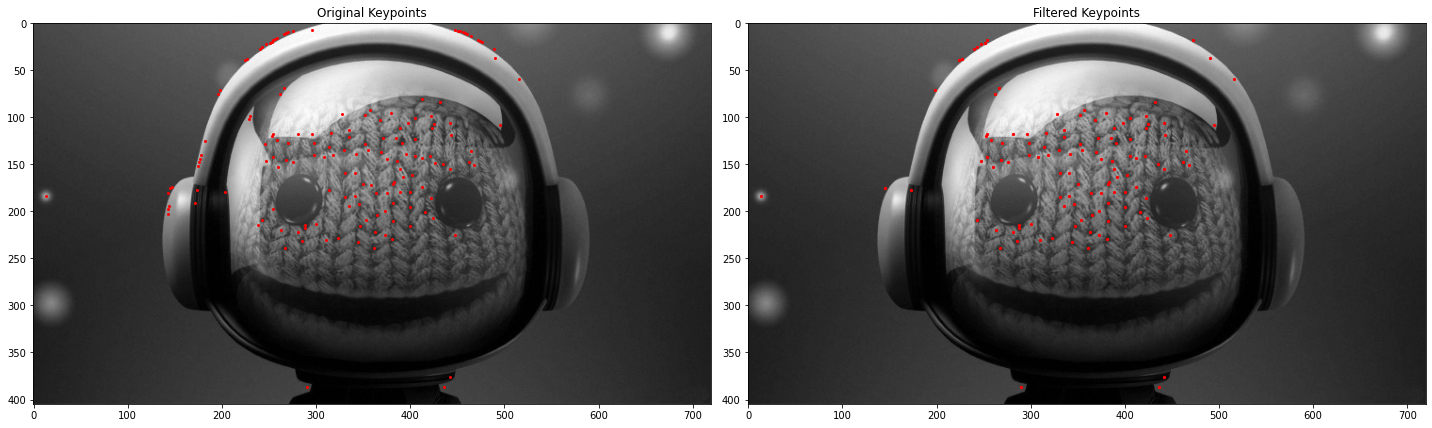

In [114]:
# plot keypoints before and after refinement
plt.figure(figsize=(20, 7))

x = [obj[0] for obj in keypoints]
y = [obj[1] for obj in keypoints]

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.scatter(x, y, s=4, c="red")
plt.title('Original Keypoints')

# Filtered Keypoints plot
keypointsarr_filtered1 = np.array(filtered_keypoints)

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.scatter(keypointsarr_filtered1[:, 0], keypointsarr_filtered1[:, 1], s=5, c="red")
plt.title('Filtered Keypoints')

plt.tight_layout()
plt.show()

## Step5: Orientation Assignment
Assign dominant orientations to keypoints.

In [115]:
def get_dominant_angles(filtered_keypoints, DoG_list):
    """
    Determines the dominant angles associated with filtered keypoints.

    Args:
    - filtered_keypoints (list of tuples): Refined keypoints after filtering.
    - orientation_data (dictionary): Contains magnitude and angle information associated with keypoints.

    Returns:
    - new_orientations_data (dictionary): Contains dominant angle(s) associated with filtered keypoints.

    Notes:
    - This function computes the dominant angle(s) for each filtered keypoint based on orientation data.
    - 'filtered_keypoints' represents keypoints refined through a previous filtering process.
    - 'orientation_data' stores magnitude and angle information for each keypoint.
    - Output 'new_orientations_data' contains the dominant angle(s) for the filtered keypoints.
    - A histogram of angles is generated, and the highest peak represents the dominant orientation.
    - Additional angles exceeding 0.8 times the peak value are considered as alternative orientations.
    """
    orientation_data = {}
    new_filtered_keypoints = []
    for kp in filtered_keypoints:
        x, y, g = kp
        img = DoG_list[g]
        
        patch_size = 16  # Size of the neighborhood patch for computing orientation
        y_start, y_end = int(y - patch_size/2), int(y + patch_size/2)
        x_start, x_end = int(x - patch_size/2), int(x + patch_size/2)
        patch = img[y_start:y_end, x_start:x_end]
        
        if(patch.shape == (patch_size, patch_size)):
            # compute magnitude and direction for the patch
            dx = convolve(patch, np.array([[1, 0, -1]]), mode='same')
            dy = convolve(patch, np.array([[1], [0], [-1]]), mode='same')
            magnitude = np.sqrt(dx**2 + dy**2).flatten()
            angle = np.degrees(np.arctan2(dy, dx)).flatten().astype(int)

            hist, bin_edges = np.histogram(angle, bins=36, range=(0, 360), weights=magnitude)
            dominant_angle_idx = np.argmax(hist)
            orientation_data[kp[:2]] = {angle[dominant_angle_idx]}
            new_filtered_keypoints.append(kp)

            # Check for additional prominent angles (>0.8 times the peak value)
            hist = np.delete(hist, dominant_angle_idx)
            other_thetas = np.argwhere(hist > 0.8).reshape(-1)

            if len(other_thetas) > 0:
                orientation_data[kp[:2]].update(set(angle[other_thetas]))
    return orientation_data, new_filtered_keypoints


## Step 6: Descriptor Generation
Create local feature descriptors around keypoints.

In [116]:
def get_hist(array, nbins=8):
    """
    Computes a histogram of gradient orientations from an input array.

    Args:
    - array (numpy array): Input array to compute the gradient orientations.
    - nbins (int): Number of bins for the histogram (default: 8).

    Returns:
    - hist (list): Histogram of gradient orientations.

    Notes:
    - Computes gradient magnitudes and angles using Sobel operators on the input array.
    - Generates a histogram of gradient angles with specified bins and magnitude weights.
    - 'nbins' determines the number of bins for the histogram.
    - Output 'hist' contains the histogram of gradient orientations.
    """
    grad_x = sobel_h(array)
    grad_y = sobel_v(array)
    magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    angle = np.arctan2(grad_x, grad_y) * 180 / np.pi

    # adjust the weight of each vector based on how far it is from keypoint
    distances = np.ones(16) * 8
    distances[5:7] = 1
    distances[9:11] = 1
    weights = 1 / (1 + distances)
    
    hist, bin_edges = np.histogram(angle.flatten(), bins=nbins, 
                   range=(0, 360), weights=weights * magnitude.flatten())
    return list(hist)


In [117]:
def get_descriptor(DoG_space, kp, rot_angle, patch_size=16, subarray_size=4, func=get_hist):
    """
    Generates a feature descriptor for a keypoint in an image.

    Args:
    - image (numpy array): The image array containing the keypoint.
    - kp (tuple): Coordinates of the keypoint (x, y).
    - rot_angle (float): Rotation angle for the descriptor.
    - patch_size (int): Size of the patch around the keypoint (default: 16).
    - subarray_size (int): Size of subarrays within the patch (default: 4).
    - func (function): Function to compute histogram (default: get_hist).

    Returns:
    - normalized_feature_vector (numpy array): Normalized feature descriptor for the keypoint.

    Notes:
    - Computes a descriptor for a keypoint by dividing the patch into subarrays.
    - Uses a specified function to compute histograms for each subarray.
    - 'patch_size' defines the size of the patch around the keypoint.
    - 'subarray_size' specifies the size of subarrays within the patch.
    - 'func' can be replaced with a different function for histogram computation.
    - Returns a normalized feature vector as the descriptor for the keypoint.
    """
    half_patch = patch_size // 2
    
    x, y, s = kp
    image = DoG_space[s]
    
    # Check boundaries
    x_start = max(x - half_patch, 0)
    y_start = max(y - half_patch, 0)
    x_end = min(x + half_patch, image.shape[1] - 1)
    y_end = min(y + half_patch, image.shape[0] - 1)
    
    patch = image[y_start:y_end, x_start:x_end]
    if patch.shape != (16, 16):
        return []
    
    # rotate patch with the dominant angle
    patch = rotate(patch, angle=-rot_angle, resize=False, preserve_range=True)
    # patch = rotate(patch, rot_angle)

    feature_vector = []
    for row in range(0, patch_size, subarray_size):
        for col in range(0, patch_size, subarray_size):
            subarray = patch[row:min(row + subarray_size, patch_size), col:min(col + subarray_size, patch_size)]
            result = func(subarray)
            feature_vector.extend(result)

    norm = np.linalg.norm(feature_vector)
    if(norm):
        normalized_feature_vector = feature_vector / norm
    else:
        normalized_feature_vector = feature_vector

    return normalized_feature_vector


In [118]:
def get_SIFT_data(img, sigmas, octave_lvls=[1], DoG_thresh=0.03, r=10):
    """
    Extracts Scale-Invariant Feature Transform (SIFT) data from an input image.

    Args:
    - img (numpy array): The input image array.
    - octave_lvls (list): List of scale levels for image pyramid generation.
    - sigmas (list): List of sigma values for Gaussian blurring at each scale level.
    - DoG_thresh (float): Threshold value for Difference of Gaussians (DoG) keypoint detection (default: 0.03).
    - r (int): Sensitivity parameter for keypoint filtering using the Hessian matrix (default: 10).
    - is_test (bool): Indicates if the function is used for testing purposes (default: False).

    Returns:
    - keypoints_list (list): List of keypoints extracted using SIFT.
    - descriptors_list (list): List of descriptors computed for each keypoint.

    Notes:
    - Computes an image pyramid with specified scale levels and Gaussian blur at different sigmas.
    - Detects keypoints using Difference of Gaussians (DoG) and filters them based on Hessian matrix analysis.
    - Determines dominant angles for filtered keypoints and computes descriptors.
    - Returns lists of keypoints and descriptors extracted using SIFT.
    - 'DoG_thresh' influences keypoint detection sensitivity in the Difference of Gaussians (DoG) process.
    - 'r' parameter affects keypoint filtering based on the Hessian matrix eigenvalues.
    """
    SIFT_summary = pd.DataFrame(columns=["Position", "Size", "Orientation", "Descriptor"])
    
    # generate different sizes of the image    
    octave = generate_octave(img, octave_lvls)
    
    scale_space = []
    for i in range(len(octave)):
        blurred_imgs = generate_different_scales(octave[i], sigmas)
        scale_space.append(blurred_imgs)

    for s, imgs_list in enumerate(scale_space):
        DoG_list = np.array(DoG(imgs_list))
        keypoints_list = get_keypoints(DoG_list, DoG_thresh)
        filtered_keypoints = filter_keypoints(keypoints_list, DoG_list, r)
        # return filtered_keypoints
        orientation_data, filtered_keypoints = get_dominant_angles(filtered_keypoints, DoG_list)
        # return orientation_data, filtered_keypoints
        start = time.time()
        for kp in filtered_keypoints:
                    for angle in orientation_data[kp[:2]]:
                        descriptor = get_descriptor(DoG_list, kp, angle)
                        if len(descriptor):
                            data = [kp, octave_lvls[s], angle, descriptor]
                            SIFT_summary.loc[len(SIFT_summary)] = data
        # print(f"Time: {time.time() - start}")
    return SIFT_summary

# Modify this function to return Only list of descriptors and a list of keypoints

In [119]:
# get descriptors of the current image
sigma = 1.6
k = np.sqrt(2)

octave_lvls = [1.0]  # Starting scale factor, e.g., 1.0
num_octave_levels = 4

for i in range(num_octave_levels - 1):
    octave_lvls.append(np.sqrt(2) * octave_lvls[-1])

sigmas = [sigma, k * sigma, k**2 * sigma, k**3 * sigma, k**4 * sigma]
%time SIFT_summary = get_SIFT_data(img, sigmas, octave_lvls)

Wall time: 3.23 s


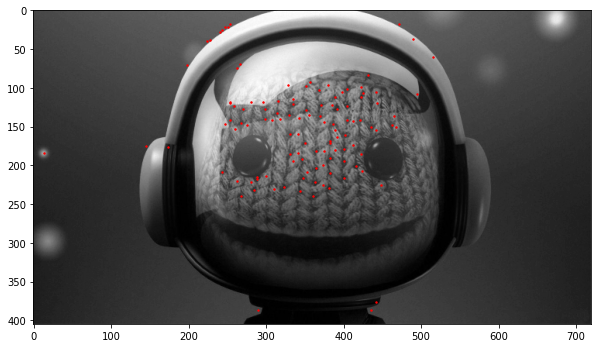

In [120]:
x, y, c = zip(*SIFT_summary[SIFT_summary["Size"] == 1]["Position"].to_list())
fig = plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the image
plt.scatter(list(x), list(y), color='red', s=2)  # Scatter plot the point (x, y) in red color
plt.show()

## Testing SIFT descriptors

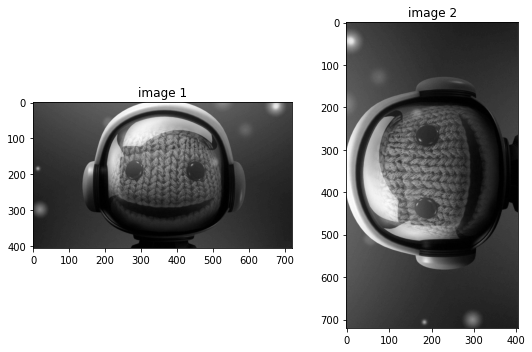

In [121]:
# Create two images sharing some common pixels
img1 = img
# img2 = rgb2gray(io.imread("img2.jpg"))
img2 = transform.rotate(img1, 90, resize=True)
show_images([img1, img2], ["image 1", "image 2"], figsize=(8, 5))

In [122]:
# Get feature points for each image
SIFT_summary1 = get_SIFT_data(img1, sigmas, DoG_thresh=0.03)
SIFT_summary2 = get_SIFT_data(img2, sigmas, DoG_thresh=0.03)

In [123]:
# Get nearest neighbor for each feature point
from sklearn.neighbors import NearestNeighbors

k_neighbors = 1  # Number of neighbors to find (in this case, the nearest neighbor)
nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='kd_tree')

# Fit the model on data2 (feature points from image 2)
nn_model.fit(SIFT_summary1["Descriptor"].to_list())

distances, indices = nn_model.kneighbors(SIFT_summary2["Descriptor"].to_list())

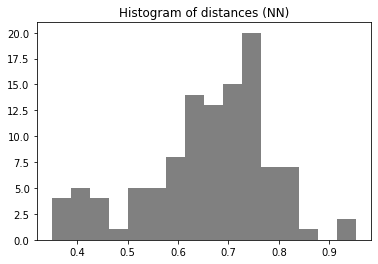

In [124]:
# plot histogram of nearest neighbors distances
_ = plt.hist(distances.reshape(-1), bins=16, color='gray');
plt.title("Histogram of distances (NN)")
plt.show()

In [125]:
# choose some threshold distance and get the corresponding feature points
max_distance = 0.4
filtered_indices = indices[distances < max_distance]
corresponding_rows_SIFT_summary1 = SIFT_summary1.iloc[filtered_indices]

# Get corresponding rows from SIFT_summary2 using filtered indices
corresponding_rows_SIFT_summary2 = SIFT_summary2.iloc[distances < max_distance]


In [126]:
# get x, y points from both SIFT summary df to plot
xy1 = np.array(corresponding_rows_SIFT_summary1["Position"].to_list())[:, :2]
x1 = xy1[:, 0]
y1 = xy1[:, 1]

xy2 = np.array(corresponding_rows_SIFT_summary2["Position"].to_list())[:, :2]
x2 = xy2[:, 0]
y2 = xy2[:, 1]

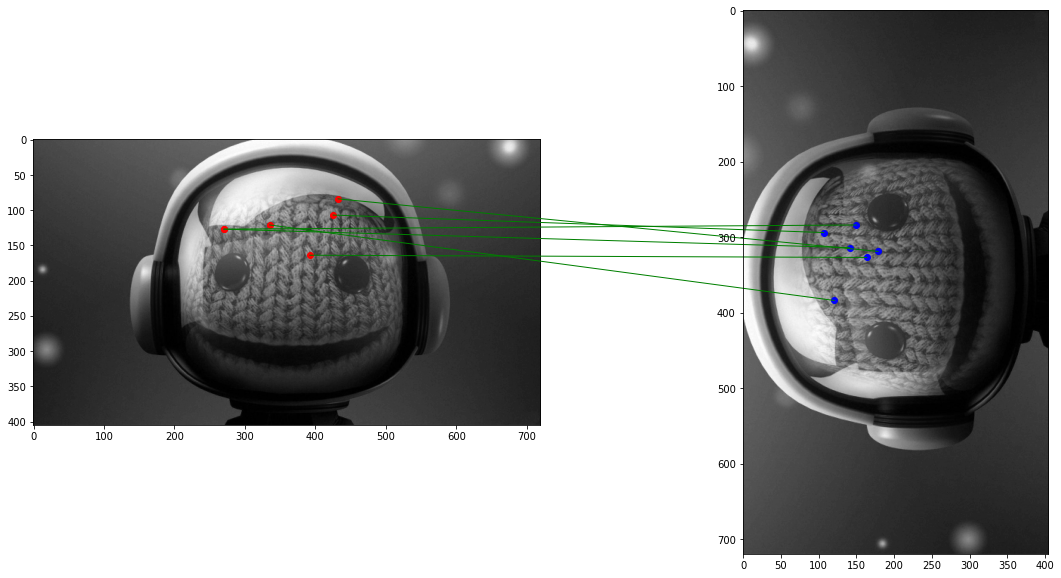

In [127]:
# Plt two scatters with connections
from matplotlib.patches import ConnectionPatch

# Creating subplots for two images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plotting scatter points on image 1
ax1.imshow(img1, cmap='gray')  # Replace with your actual image 1
ax1.scatter(x1, y1, color='red')

# Plotting scatter points on image 2
ax2.imshow(img2, cmap='gray')  # Replace with your actual image 2
ax2.scatter(x2, y2, color='blue')

# Connecting points with ConnectionPatch
for i in range(len(x1)):
    xyA = (x1[i], y1[i])
    xyB = (x2[i], y2[i])
    con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="green")
    ax2.add_artist(con)

plt.show()


In [128]:
# Initialize SIFT detector
sift = cv2.SIFT_create()
img1 = (img1 * 255).astype(np.uint8)
img2 = (img2 * 255).astype(np.uint8)

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Initialize a BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()

# Match descriptors of both images
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Get common keypoints
common_keypoints_img1 = [keypoints1[match.queryIdx] for match in good_matches]
common_keypoints_img2 = [keypoints2[match.trainIdx] for match in good_matches]

# Draw common keypoints on both images
img1_with_keypoints = cv2.drawKeypoints(img1, common_keypoints_img1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_with_keypoints = cv2.drawKeypoints(img2, common_keypoints_img2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show images with common keypoints
cv2.imshow('Image 1 with Common Keypoints', img1_with_keypoints)
cv2.imshow('Image 2 with Common Keypoints', img2_with_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()

# RANSAC algorithm to get affine matrix with nearest neighbor
Given that we have two images, the steps are as follows:
1. Get feature points of both images
2. Get nearest neighbors from image2 for all feature poins in image1
3. Sum distances and store it with it's model in a variable called best matrix
4. Take 3 random points and make an affine matrix
5. Transform the image by the affine matrix
6. Get feature points for image2
7. Repeat steps from 2 - 6

In [131]:
def get_affine_matrix(df1, df2, model):
    # while True:
    # get three random points x, y
    sample_points_df = df2.sample(3)
    
    # Extracting the Position data and creating the matrix
    src_pts = np.array(sample_points_df['Position'].to_list())[:, :2] #.T
        # matrix1_H = np.vstack([matrix1_H, np.ones(3)])
        
        # # Attempting to find the inverse
        # try:
        #     matrix1_H_inv = np.linalg.inv(matrix1_H)
        #     break  # Break the loop if the inverse is found
        # except np.linalg.LinAlgError:  # Handles non-invertible matrix
        #     pass  # If not invertible, continue to the next iteration


    # get x`, y`
    distances, indices = model.kneighbors(sample_points_df["Descriptor"].to_list())

    # Convert the indices into a flattened NumPy array
    flat_indices = indices.ravel()

    # Locate rows at specified indices using take for x`, y`
    selected_rows = df1.take(flat_indices)
    dst_pts = np.array(selected_rows['Position'].to_list())[:, :2]  #.T
    # matrix2_H = np.vstack([matrix2_H, np.ones(3)])

    # Calculate the affine transformation matrix
    # affine_matrix = np.dot(matrix2_H, matrix1_H_inv)
    # Estimate affine matrix using RANSAC
    print(src_pts.shape, dst_pts.shape)
    affine_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                        method=cv2.RANSAC, 
                                                        ransacReprojThreshold=3.0)

    return affine_matrix

In [132]:
import numpy as np
import cv2

def get_affine_matrix(df1, df2, model, threshold):
    sample_points_df = df2.sample(3)
    dst_pts = np.array(df2['Position'].to_list())[:, :2]

    distances, indices = model.kneighbors(df2["Descriptor"].to_list())
    flat_indices = indices.ravel()
    selected_rows = df1.take(flat_indices)
    src_pts = np.array(selected_rows['Position'].to_list())[:, :2]

    # Check the shapes of src_pts and dst_pts
    print("Shape of src_pts:", src_pts.shape)
    print("Shape of dst_pts:", dst_pts.shape)

    # Estimate affine matrix using RANSAC
    
    affine_matrix, inliers = cv2.estimateAffinePartial2D(src_pts.astype(np.float32), dst_pts.astype(np.float32), 
                                                        method=cv2.RANSAC, 
                                                        ransacReprojThreshold=threshold,
                                                        maxIters=10000,
                                                        refineIters = 100 )

    return affine_matrix


Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


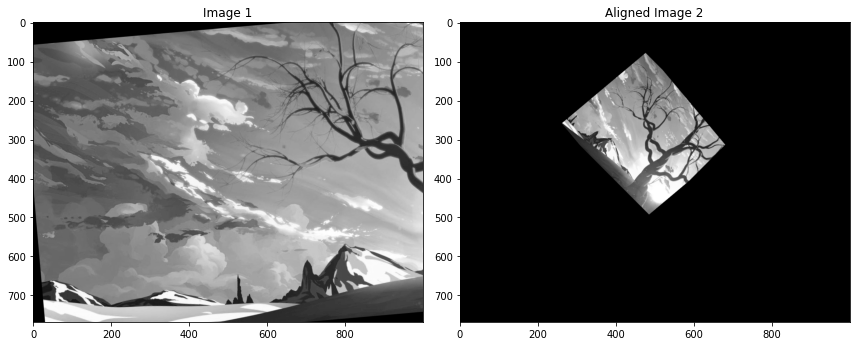

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


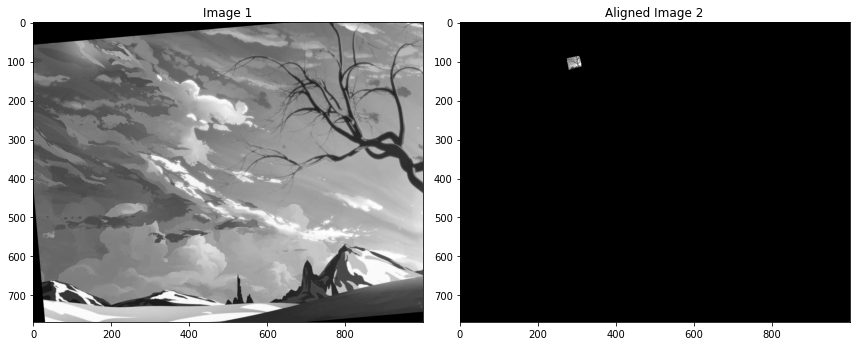

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


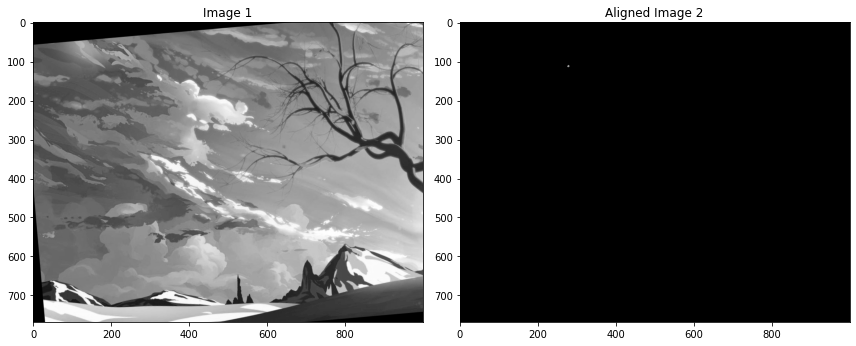

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


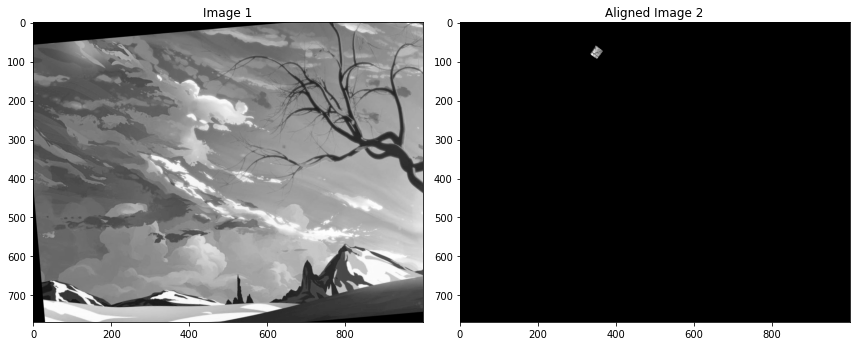

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


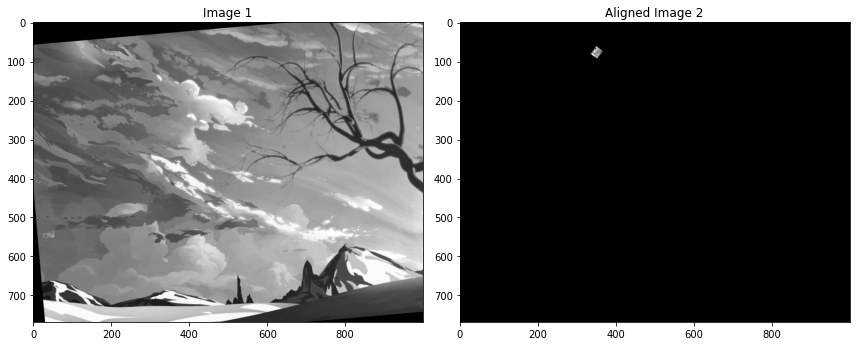

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


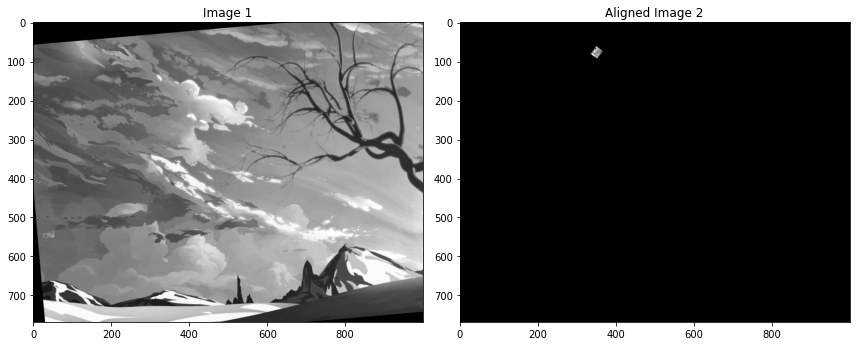

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


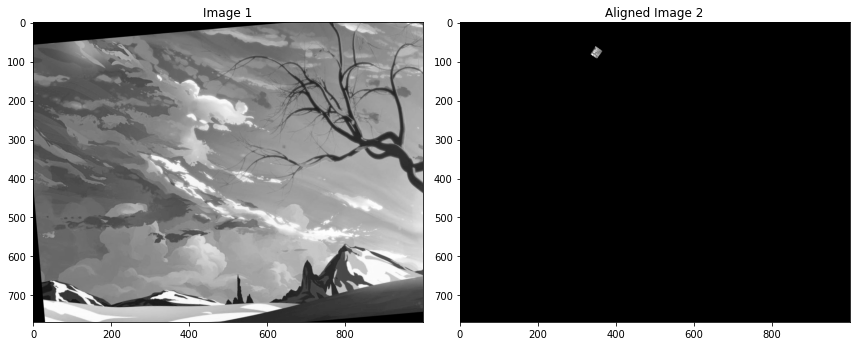

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


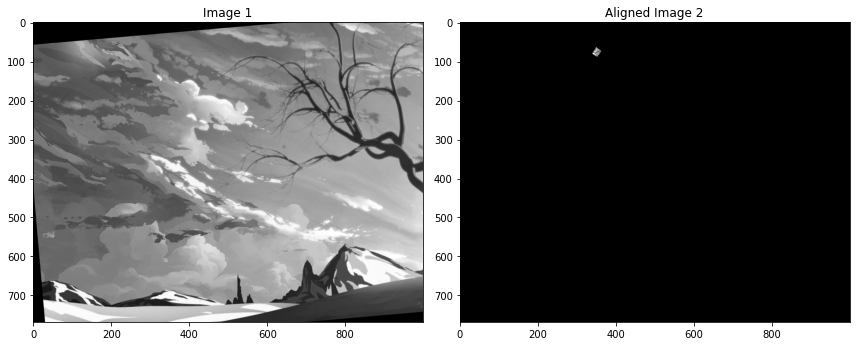

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


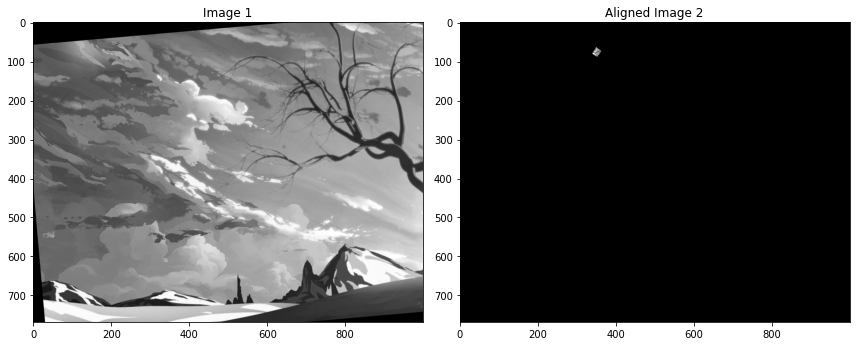

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


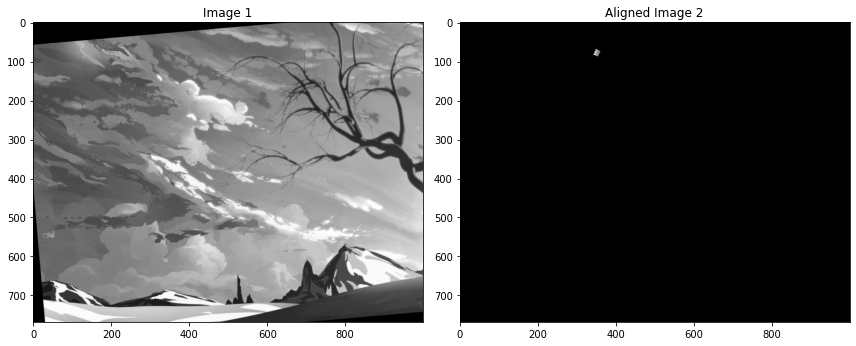

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


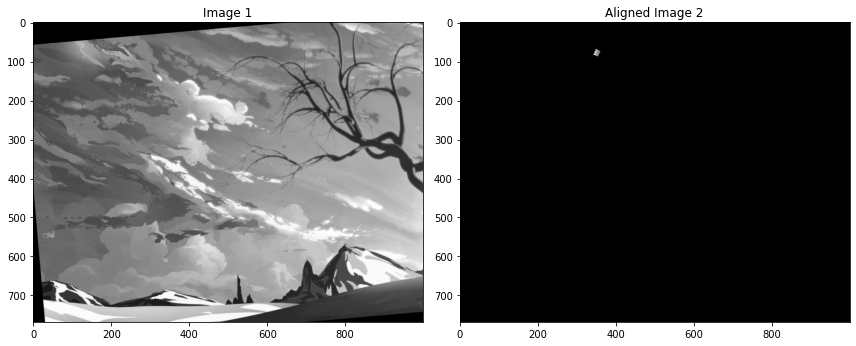

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


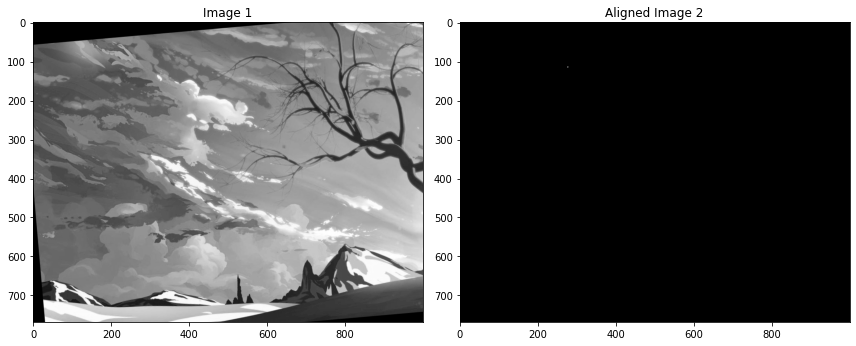

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


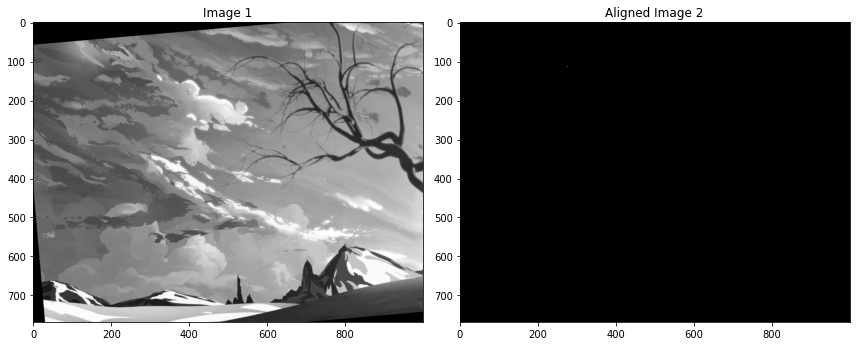

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


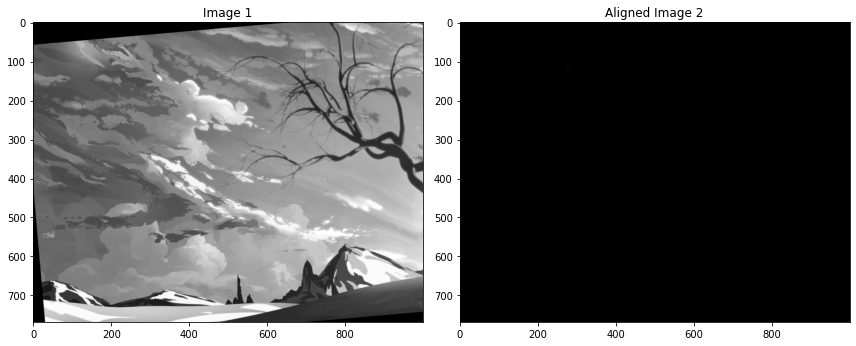

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


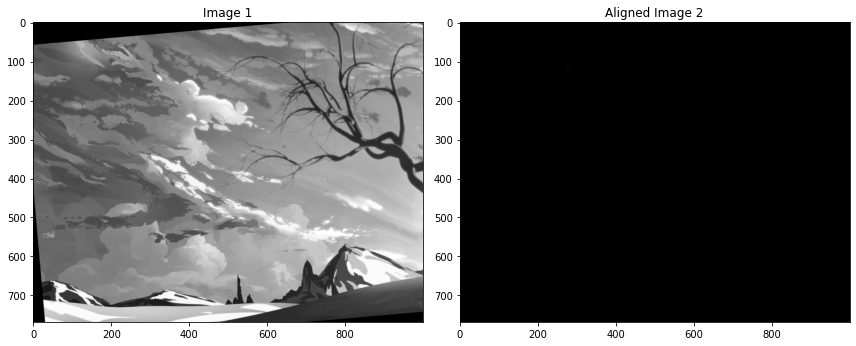

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


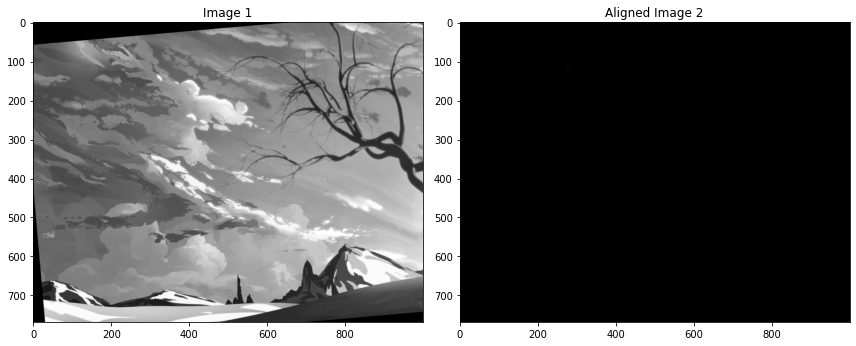

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


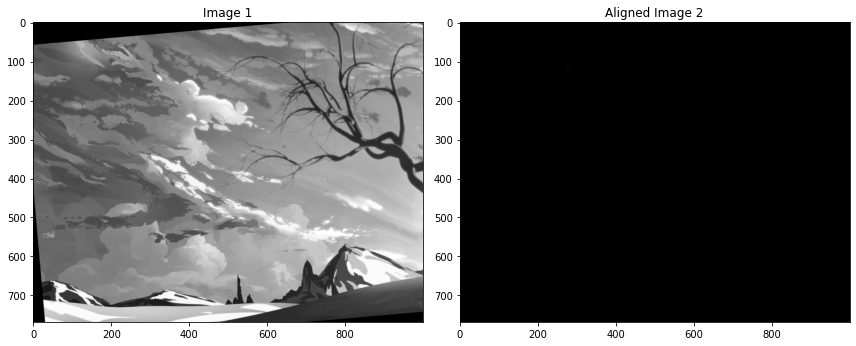

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


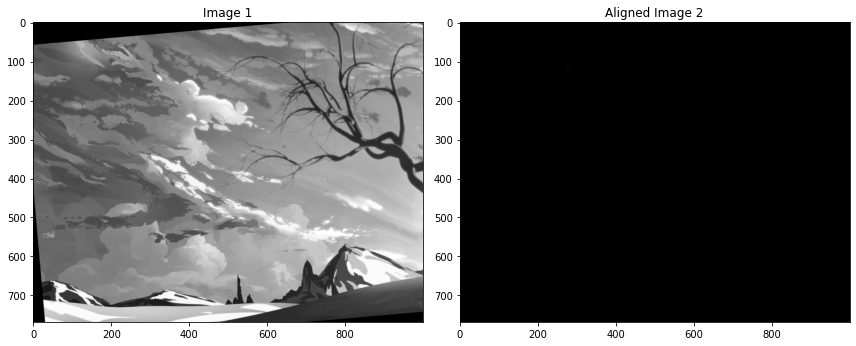

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


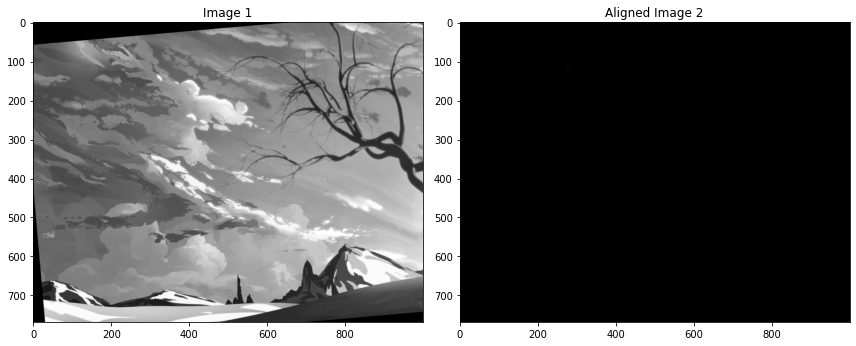

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


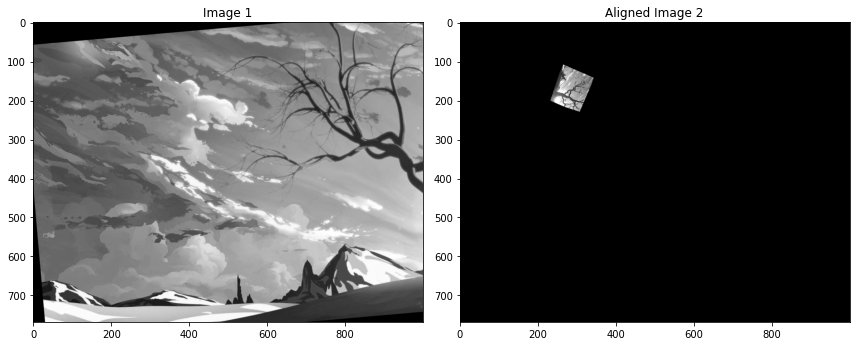

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


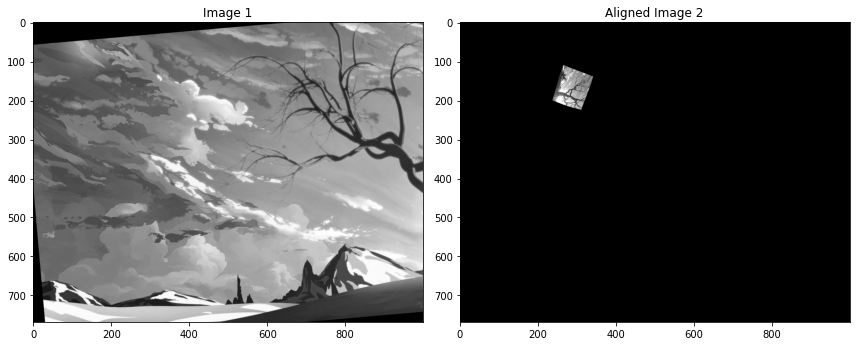

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


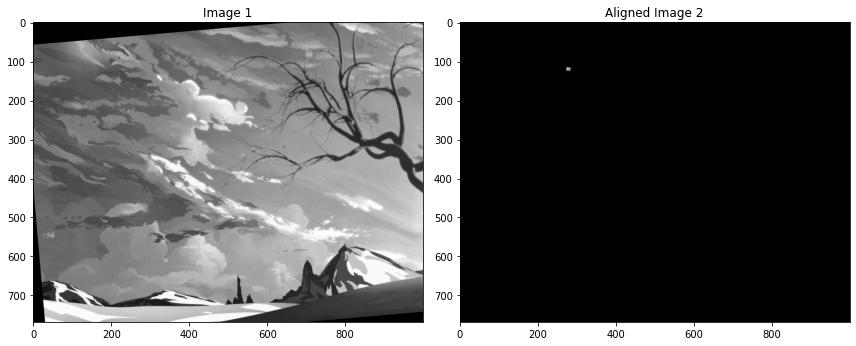

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


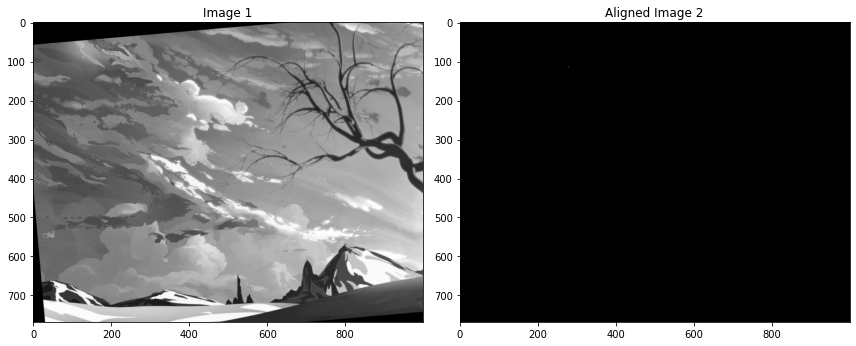

Shape of src_pts: (487, 2)
Shape of dst_pts: (487, 2)


KeyboardInterrupt: 

In [133]:
# Convert images to 8-bit format
image1_8bit = np.uint8(img1 * 255)
image2_8bit = np.uint8(img2 * 255)

for i in range(50):
    a_m = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model, i)
    # Apply the perspective transformation to the image
    a_m = np.vstack([a_m, np.array([0, 0 ,1])])
    result = cv2.warpPerspective(img2, a_m, (img1.shape[1], img1.shape[0]))

    # Visualize the resulta_m = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap='gray')
    plt.title('Aligned Image 2')

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors
best_matrix_error = 1e8

# Get descriptors for both images
SIFT_summary1 = get_SIFT_data(img1, sigmas, octave_lvls)
SIFT_summary2 = get_SIFT_data(img2, sigmas, octave_lvls)

descriptor1 = SIFT_summary1["Descriptor"].to_list()
descriptor2 = SIFT_summary2["Descriptor"].to_list()

# Initialize NearestNeighbors
k_neighbors = 1  # Number of neighbors to find (in this case, the nearest neighbor)
nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='kd_tree')

# Fit the model on data2 (feature points from image 2)
nn_model.fit(descriptor1)


# affine_matrix = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model)

# transform the image by the matrix
# Get the height and width of the image
height, width = img2.shape[:2]

# Apply the affine transformation using warpAffine function from OpenCV
# transformed_image = cv2.warpAffine(img2, affine_matrix[:2, :], (width, height))


for i in range(50):
    affine_matrix = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model)
    transformed_image = cv2.warpAffine(img2, affine_matrix[:2, :], (width, height))
    
    SIFT_summary_transformed = get_SIFT_data(transformed_image, sigmas)
    descriptor_transformed_img = SIFT_summary_transformed["Descriptor"].to_list()

    if(len(descriptor_transformed_img)):
        # Query the nearest neighbors for each point in data1
        distances, indices = nn_model.kneighbors(descriptor_transformed_img)

        error = np.sum(distances)
        # Get the height and width of the image
        height, width = img2.shape[:2]

        # Apply the affine transformation using warpPerspective function from OpenCV
        transformed_image = cv2.warpPerspective(img2, affine_matrix, (width, height))

        # Display the image inline using Matplotlib
        plt.imshow(transformed_image, cmap='gray')
        plt.title(f"Error: {error}")
        plt.axis('off')  # Optional: turn off axis labels
        plt.show()
        if error < best_matrix_error:
            best_matrix_error = error
            best_matrix = affine_matrix





In [ ]:
import cv2
import numpy as np

# Define source and destination points
src_pts = np.array([[561, 223], [99, 539], [529, 60]])
dst_pts = np.array([[822, 337], [823, 148], [303, 404]])

# Estimate affine matrix using RANSAC
affine_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                     method=cv2.RANSAC, 
                                                     ransacReprojThreshold=3.0)

if affine_matrix is not None:
    print("Estimated Affine Matrix:")
    print(affine_matrix)
else:
    print("Affine matrix estimation failed.")

# Use affine_matrix for your transformations if it was successfully estimated


Estimated Affine Matrix:
[[-1.92103415e-01 -2.77695500e-01  9.91696112e+02]
 [ 2.77695500e-01 -1.92103415e-01  2.24051886e+02]]


In [ ]:
src_pts.shape

(3, 2)

In [ ]:
# RANSAC parameters
ransac_iterations = 1000  # Number of RANSAC iterations
ransac_threshold = 3.0    # Threshold to determine inliers

# Estimate affine matrix using RANSAC
affine_matrix, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, 
                                                     method=cv2.RANSAC, 
                                                     ransacReprojThreshold=ransac_threshold,
                                                     maxIters=5000)


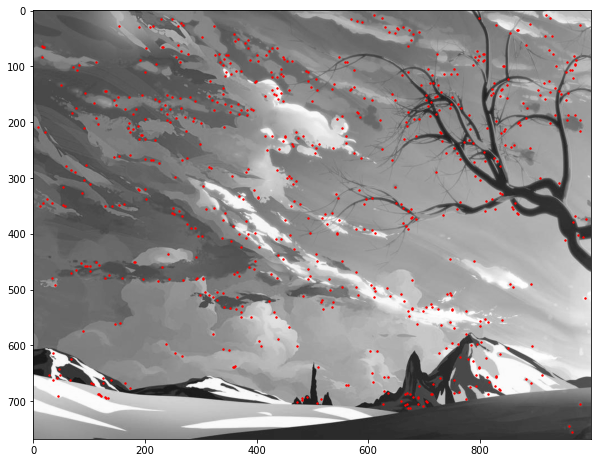

In [ ]:
x1, y1, c = zip(*SIFT_summary1['Position'].to_list())
fig = plt.figure(figsize=(10, 8))
plt.imshow(img1, cmap='gray')  # Display the image
plt.scatter(list(x1), list(y1), color='red', s=2)  # Scatter plot the point (x, y) in red color
plt.show()

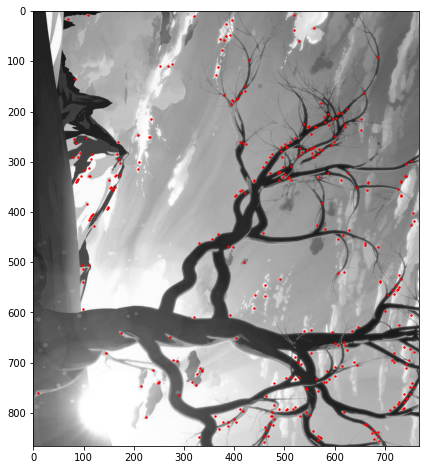

In [ ]:
x2, y2, c = zip(*SIFT_summary2['Position'].to_list())
fig = plt.figure(figsize=(10, 8))
plt.imshow(img2, cmap='gray')  # Display the image
plt.scatter(list(x2), list(y2), color='red', s=2)  # Scatter plot the point (x, y) in red color
plt.show()

In [ ]:
distances, indices = nn_model.kneighbors(descriptor2)


In [ ]:
len(keypoints2)

1902

In [ ]:
affine_matrix = get_affine_matrix(SIFT_summary1, SIFT_summary2, nn_model)

# transform the image by the matrix
# Get the height and width of the image
height, width = img2.shape[:2]

# Apply the affine transformation using warpAffine function from OpenCV
transformed_image = cv2.warpAffine(img2, affine_matrix[:2, :], (width, height))

NameError: name 'get_affine_matrix' is not defined

In [ ]:
affine_matrix.astype(int)

array([[   0,    0, 1404],
       [   0,    0,  213],
       [   0,    0,    1]])

In [ ]:
cv2.imshow('Transformed Image', transformed_image)
cv2.waitKey(0)  # Wait until a key is pressed
cv2.destroyAllWindows()  # Close the window


In [ ]:
np.vstack([matrix2_H, np.ones(3)])

array([[731., 882., 507.],
       [146., 192., 246.],
       [  1.,   1.,   1.]])

In [ ]:
# get nearest neighbors
# Initialize NearestNeighbors
k_neighbors = 1  # Number of neighbors to find (in this case, the nearest neighbor)
nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto')

# Fit the model on data2 (feature points from image 2)
nn_model.fit(data2)

# Query the nearest neighbors for each point in data1
distances, indices = nn_model.kneighbors(data1)


## Nearest Neighbor search between two images to find similar keypoints

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# test on a new rotated image
img2 = transform.rotate(img, 16, resize=False)

# fit the nn model on the original image
nn = NearestNeighbors(n_neighbors=1, algorithm="kd_tree").fit(np.array(
    SIFT_summary["Descriptor"].tolist()))

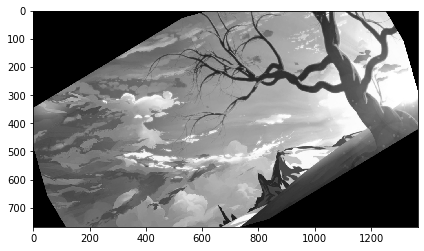

In [ ]:
io.imshow(img2)

In [ ]:
# get descriptors of the new image
sigma = 1.6
k = np.sqrt(2)
octave_lvls = [1, 2, 3, 6]
sigmas = [sigma, k * sigma, k**2 * sigma, k**3 * sigma, k**4 * sigma]
%time SIFT_summary1 = get_SIFT_data(img2, sigmas)

Time: 2.520292043685913
Wall time: 3.12 s


In [ ]:
# choose a random feature point from the second image
test_point = SIFT_summary1.sample(1)

# find the nearest neighbor
distances, indices = nn.kneighbors(np.array(test_point["Descriptor"].to_list()), n_neighbors=8)

In [ ]:
test_point

Position  Scale  Orientation  \
46  (1295, 164, 1)    1.6           16   

                                           Descriptor  
46  [0.0, 0.17327229552208492, 0.25661406718491264...

In [ ]:
SIFT_summary.loc[indices[0]]

Position     Scale  Orientation  \
70   (1315, 230, 1)  1.600000           30   
321    (323, 72, 1)  2.262742           29   
63    (686, 213, 1)  1.600000           16   
376   (669, 298, 1)  2.262742           26   
522   (285, 202, 1)  3.200000           29   
333   (339, 105, 1)  2.262742           16   
74   (1304, 233, 1)  1.600000           16   
209   (684, 212, 2)  1.600000           16   
586     (69, 62, 2)  4.525483           15   
19     (770, 86, 1)  1.600000           25   
307    (578, 31, 1)  2.262742           16   
216  (1302, 233, 2)  1.600000           16   
499    (259, 83, 1)  3.200000           14   
154   (1096, 24, 2)  1.600000           25   
40    (662, 152, 1)  1.600000           17   
343   (259, 123, 1)  2.262742           27   
379   (477, 308, 1)  2.262742           16   
498    (431, 78, 1)  3.200000           28   
83    (739, 255, 1)  1.600000           15   
446   (627, 193, 2)  2.262742           16   
287   (351, 597, 2)  1.600000           16   
293   (897, 625, 2)  1.600000           28   
515   (135, 149, 1)  3.200000           16   
117   (450, 474, 1)  1.600000           14   
1     (1045, 15, 1)  1.600000           29   
512   (354, 134, 1)  3.200000           14   
246   (731, 327, 2)  1.600000           20   
493    (238, 69, 1)  3.200000           31   
367   (618, 245, 1)  2.262742           21   
39    (183, 149, 1)  1.600000           16   
312    (327, 42, 1)  2.262742           18   
506    (333, 94, 1)  3.200000           19   
61    (737, 212, 1)  1.600000           16   
68    (805, 227, 1)  1.600000           30   
62   (1302, 212, 1)  1.600000           16   
3     (1129, 24, 1)  1.600000           13   
81    (732, 249, 1)  1.600000           16   
342   (439, 121, 1)  2.262742           21   
290   (879, 613, 2)  1.600000           17   
35    (668, 141, 1)  1.600000           15   
88   (1206, 298, 1)  1.600000           15   
348   (485, 152, 1)  2.262742           17   
152    (881, 17, 2)  1.600000           20   
505    (312, 91, 1)  3.200000           25   
75    (796, 235, 1)  1.600000           27   
588     (88, 84, 2)  4.525483           17   
323    (453, 76, 1)  2.262742           28   
466   (475, 308, 2)  2.262742           19   
524   (280, 220, 1)  3.200000           27   
150   (360, 758, 1)  1.600000           22   

                                            Descriptor  
70   [0.0, 0.32305592820827017, 0.02880471714830384...  
321  [0.0, 0.057885427798925186, 0.084438428408698,...  
63   [0.0, 0.016981582925963946, 0.2898888124599836...  
376  [0.0, 0.18151392986832302, 0.09154139880340222...  
522  [0.12750765350834325, 0.301132713178751, 0.0, ...  
333  [0.0, 0.01972466867170946, 0.2821055113514398,...  
74   [0.0, 0.12182274431114931, 0.2180930429344094,...  
209  [0.0, 0.020645906431204307, 0.2819758134561442...  
586  [0.009525789548127573, 0.12127880996166232, 0....  
19   [0.05471161347734664, 0.15715476926020192, 0.0...  
307  [0.0, 0.0, 0.17565347979615573, 0.049725309775...  
216  [0.001661720747617629, 0.19058499792380856, 0....  
499  [0.0, 0.0, 0.013526510751391047, 0.09304619601...  
154  [0.012013646195392452, 0.5297751319570466, 0.0...  
40   [0.0, 0.0, 0.0492917911998142, 0.2024004648846...  
343  [0.0015793585614181879, 0.016581550189745258, ...  
379  [0.0, 0.0, 0.1056162701565373, 0.0483651848366...  
498  [0.0, 0.05776282059852885, 0.28523299173412076...  
83   [0.0, 0.0, 0.37151407326492075, 0.071080673658...  
446  [0.0, 0.2640343794843814, 0.36767549202497474,...  
287  [0.09860974418901367, 0.286668656189648, 0.0, ...  
293  [0.0, 0.5152493157603231, 0.004033788988218451...  
515  [0.0, 0.0, 0.2680355712368385, 0.0308829344589...  
117  [0.0, 0.2033300557290853, 0.0, 0.0, 0.0, 0.0, ...  
1    [0.0, 0.19972810255864698, 0.1849999099905914,...  
512  [0.0, 0.0, 0.4119321177130367, 0.1192735852771...  
246  [0.006018550608698704, 0.08653924480823057, 0....  
493  [0.0, 0.08773261774968191, 0.08584127053095895...  
367  [0.0, 

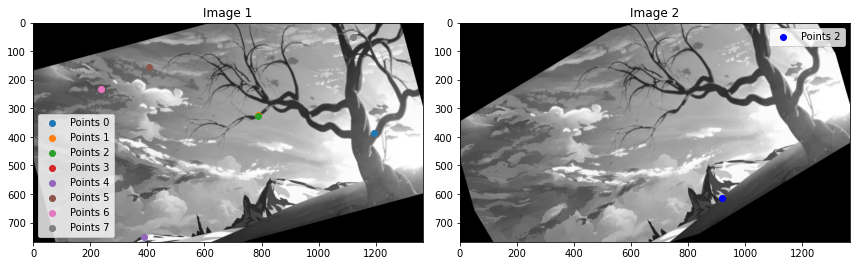

In [ ]:
# plot the two points
x2, y2, _ = test_point["Position"].to_list()[0]


# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display img in the first subplot
ax1.imshow(img, cmap='gray')
ax1.set_title('Image 1')

# Add scatter plot of x1, y1 on img
for i in range(8):
    x1, y1 = SIFT_summary.loc[indices[0]]["Position"].to_list()[i][:2]
    ax1.scatter(x1, y1, marker='o', label=f'Points {i}')
    ax1.legend()

# Display img2 in the second subplot
ax2.imshow(img2, cmap='gray')
ax2.set_title('Image 2')

# Add scatter plot of x2, y2 on img2
ax2.scatter(x2, y2, c='blue', marker='o', label='Points 2')
ax2.legend()

plt.tight_layout()
plt.show()


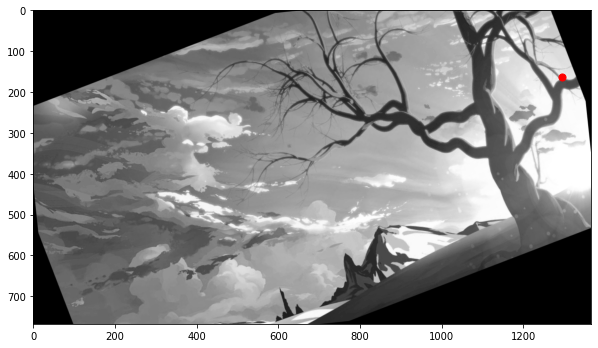

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(img2, cmap='gray')  # Display the image
plt.scatter(x, y, color='red', s=50)  # Scatter plot the point (x, y) in red color
plt.show()

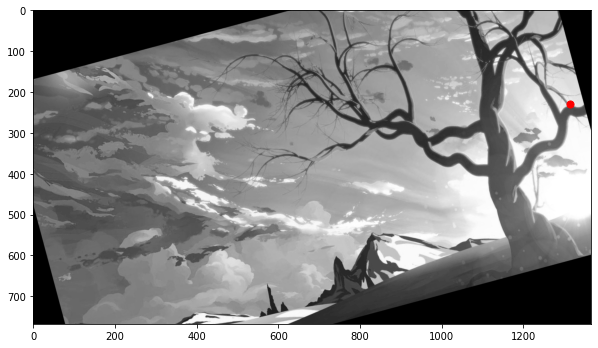

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')  # Display the image
for i in range(1):
    x, y = SIFT_summary.loc[indices[0]]["Position"].to_list()[i][:2]
    plt.scatter(x, y, color='red', s=50)  # Scatter plot the point (x, y) in red color
plt.show()

In [ ]:
test_point["Descriptor"]

10808    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010...
Name: Descriptor, dtype: object

In [ ]:
SIFT_summary.loc[indices[0]]["Descriptor"]

3636     [0.0, 0.0, 0.0, 0.008713706298182623, 0.0, 0.0...
3633     [0.0, 0.0, 0.0, 0.011546661183370116, 0.0, 0.0...
3635     [0.0, 0.0, 0.0, 0.009636456161153287, 0.0, 0.0...
3634     [0.0, 0.0, 0.0, 0.01066978708340055, 0.0, 0.0,...
15148    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...
15150    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...
3637     [0.0, 0.0, 0.0, 0.008183506395345149, 0.0, 0.0...
3632     [0.0, 0.0, 0.0, 0.05611913901331921, 0.0, 0.0,...
15149    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.049...
746      [0.0, 0.0, 0.003761142592971592, 0.0, 0.0, 0.0...
Name: Descriptor, dtype: object

1. Get nearest neighbors
2. Get affine matrix using ransac
3. optimize using LM